In [5]:
# TO-DO 1: Create data for empty seconds if there are lags where the second difference is > 1 and it's not due to a day of difference
# TO-DO 2: Use same parsing than above (by timestamp ranges) at the end of this notebook for removing last minute and first minute (60 rows) of the day.
# IMPORTANT! WE DON'T NEED TO DELETE THE FIRST AND LAST MINUTE ANYMORE, WE CAN KEEP ONE HOUR BEFORE AND AFTER TILL THE END
# TO DECIDE THE LABEL THIS WAY, AND THEN DELETE THIS EXTRA TIMES BUT HAVE LABELS FOR THE FIRST N AND LAST INSTANCES.
# TO-DO 3: Check flag 'suspicious'.
# TO-DO 4: Check avg number/plot of amount missing records/values daily in terms of proportion, 
#           to measure the real impact in the dataset and report it in the paper.
# TO-DO 5: Propagate properly the milliseconds variable when resampling.

In [6]:
# Data preparation at one-second level for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

#Alpha Vantage API to download 15 days of minute data (only if required)
from alpha_vantage.timeseries import TimeSeries
apikey='E8HE93TKWNLCACEU'
ts = TimeSeries(key=apikey)

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [7]:
dataframes=[]

# Dec 2016 (devset) + Jan to March 2017
files = ["20161201", "20161202", "20161205", "20161206", "20161207", "20161208", 
         "20161209", "20161212", "20161213", "20161214", "20161215", "20161216", 
         "20161219", "20161220", "20161221", "20161222", "20161223", "20161227", 
         "20161228", "20161229", "20161230", "20170103", "20170104", "20170105", 
         "20170106", "20170109", "20170110", "20170111", "20170112", "20170113",
         "20170117", "20170118", "20170119", "20170120", "20170123", "20170124", 
         "20170125", "20170126", "20170127", "20170130", "20170131", "20170201", 
         "20170202", "20170203", "20170206", "20170207", "20170208", "20170209", 
         "20170210", "20170213", "20170214", "20170215", "20170216", "20170217", 
         "20170221", "20170222", "20170223", "20170224", "20170227", "20170228", 
         "20170301", "20170302", "20170303", "20170306", "20170307", "20170308", 
         "20170309", "20170310", "20170313", "20170314", "20170315", "20170316", 
         "20170317", "20170320", "20170321", "20170322", "20170323", "20170324", 
         "20170327", "20170328", "20170329", "20170330", "20170331"]

for file in files:
    csv_path="/home/cetrulin/Desktop/Andres/data/raw/quantquote/1-second-level/SPY/"+file+"/spy.csv"
    new_df=pd.read_csv(csv_path, sep=',', parse_dates=True,infer_datetime_format=True, header=0)
    new_df.columns = ['milliseconds','open','high','low','close','volume','suspicious']
    new_df=new_df.astype('double', copy=False) # All values as Double
    new_df['datetime'] = pd.Timestamp(file+' 00:00:00') # Get date from foldername
    dataframes.append(new_df)

# concat all dataframes in a single one
df=pd.concat(dataframes) # 57375 rows until 2017-11-18 
df=df.drop_duplicates(['milliseconds','open','high','low','close','volume','suspicious','datetime']) # 21087 rows without duplicates

# Parse datetime at 00:00 to timestamp and multiply by 1000 to have milliseconds. 
# Then add raw timestamp with milliseconds from 00:00
df['timestamp'] = ((df.datetime.values.astype(np.int64) // 10 ** 9) * 1000) + df.milliseconds
# Timestamp in milliseconds to readable datetime
df['timestamp_r'] = pd.to_datetime(df.timestamp,unit='ms')

#df.drop also drops the selected column (if value=1) or rows (if =0) #df = df.drop(df.columns[[0]], 1)
#df = df.drop('milliseconds', 1)
df = df.drop('datetime', 1)

# Save raw concatenated file in analysis
#df.to_csv('/home/cetrulin/Desktop/Andres/data/analysis/S&P500/SPY_seconds_['+str(files[0])+'_to_'+str(files[len(files)-1])+'].csv', sep=';', compression='gzip') #encoding='utf-8')

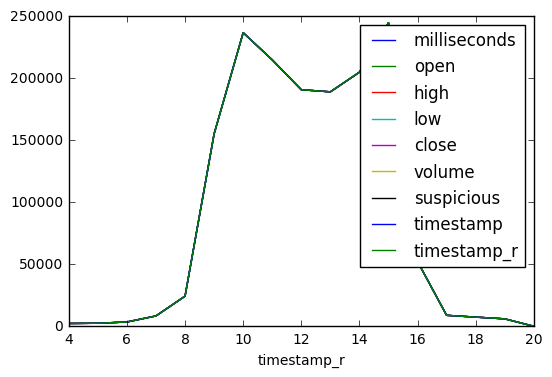

In [8]:
# Analyzing density of instances per hour
%matplotlib inline
df.groupby( [df.timestamp_r.dt.hour] ).count().plot()


In [9]:
# Only keep market hours. Decide where should the cut-off be. I get data from 4am to 8pm...
# Accoring to Quantquode, they may give hours before and after market if they have them. 
# But they give market hours from 9:30H to 16:00H. This is translated to 13.30H to 20:00H in Dublin time.
# by now I get prices from 9H to 20H as the granularity before 9H is not that good. 
# Ideally it should be only market hours, but I'm too afraid to loose valuable data.

# 08:00h = 28800000 in ms | 09:00h corresponds to millisecond 32400000 | 09:30h = 34200000 in ms
# 16:00h = 57600000 in ms | 17:00h = 61200000 in ms | 20:00h corresponds to millisecond 72000000

df=df.loc[(df['milliseconds'] >= 34200000.0) & (df['milliseconds'] <= 57600000.0)]
df
#df = df.drop('milliseconds', 1) # not drop. needed for parsing after

,milliseconds,open,high,low,close,volume,suspicious,timestamp,timestamp_r
905,34200000.0,2206900.0,2207300.0,2206900.0,2207000.0,602866.0,0.0,1.480585e+12,2016-12-01 09:30:00
906,34201000.0,2207100.0,2207100.0,2206700.0,2206700.0,13082.0,0.0,1.480585e+12,2016-12-01 09:30:01
907,34202000.0,2206965.0,2207300.0,2206700.0,2206800.0,3136.0,0.0,1.480585e+12,2016-12-01 09:30:02
908,34203000.0,2206700.0,2206800.0,2206600.0,2206700.0,3378.0,0.0,1.480585e+12,2016-12-01 09:30:03
909,34204000.0,2206600.0,2206700.0,2206300.0,2206300.0,44701.0,0.0,1.480585e+12,2016-12-01 09:30:04
910,34205000.0,2206400.0,2207100.0,2206100.0,2206100.0,25753.0,0.0,1.480585e+12,2016-12-01 09:30:05
911,34206000.0,2206100.0,2206200.0,2205900.0,2206100.0,16381.0,0.0,1.480585e+12,2016-12-01 09:30:06
912,34207000.0,2206100.0,2207300.0,2206000.0,2206000.0,13660.0,0.0,1.480585e+12,2016-12-01 09:30:07
913,34208000.0,2206100.0,2206100.0,2206000.0,2206100.0,4230.0,0.0,1.480585e+12,2016-12-01 09:30:08
914,34209000.0,2206050.0,2206300.0,2206000.0,2206100.0,12332.0,0.0,1.480585e+12,2016-12-01 09:30:09


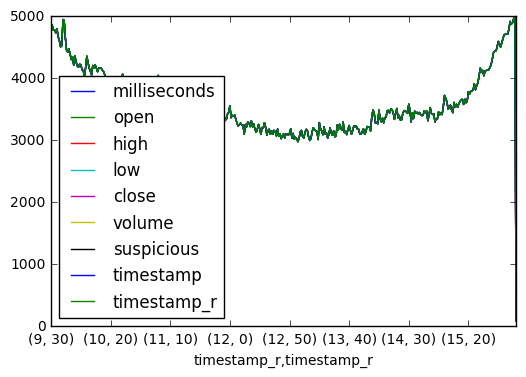

In [10]:
# Analyzing density of instances per (hour,minute) tuple. 
%matplotlib inline
#df.groupby( [df.timestamp_r.dt.hour, df.timestamp_r.dt.minute]).count()
df.groupby( [df.timestamp_r.dt.hour, df.timestamp_r.dt.minute]).count().plot()
# The expected output is to see how there is more variation at the start and closing of the market

In [11]:
# Index dataframe by its actual readable timestamp
df.index=df['timestamp_r']

In [12]:
# Missing data handling

# Disabled by default
fill_missing_values = 0

# This would be the logic for downsampling/go to minute level from seconds.
# For seconds, when upsampling like in our quantquote data, the values will be NULL anyway
ohlc_dict = {'open':'first','high':'max','low':'min','close':'last','volume':'sum'}

# Volume at 0 for missing seconds and propagate last closing price to the 4 price columns.
if (fill_missing_values == 1):
    test=df.resample('1s').agg(ohlc_dict)
    test['volume'] = test['volume'].fillna(0) 
    test['close'] = test['close'].ffill()     
    test['open'] = test['open'].fillna(test['close']) 
    test['low'] = test['low'].fillna(test['close']) 
    test['high'] = test['high'].fillna(test['close'])
    #test['milliseconds'] = test['milliseconds'].fillna(test['milliseconds'].shift(-1) + 1000)  # test this
    df=test

# Propagate all columns
elif (fill_missing_values == 2):
    test=df.resample('1s').agg(ohlc_dict)
    test['volume'] = test['volume'].ffill()
    test['close'] = test['close'].ffill()     
    test['open'] = test['open'].ffill()
    test['low'] = test['low'].ffill()
    test['high'] = test['high'].ffill()
    #test['milliseconds'] = test['milliseconds'].fillna(test['milliseconds'].shift(-1) + 1000) # test this
    df=test

In [14]:
minute_level = True

if (minute_level == True):
    df = df.resample('1Min').agg({'open': 'first', 
                                'high': 'max',
                                'low': 'min', 
                                'close': 'last',
                                'volume': 'sum'})

In [15]:
#Add parameters to transform in TS
timeseries=['low','close','open','high','volume']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3

use_OHLCV_timeseries = False
OHLCV_timeseries_lenght = 4

# Add lagged times
if (use_OHLCV_timeseries == True):
    for column in timeseries:
        #df[column+'_t']=df[column]
        for i in range(1,length):
            df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
        #del drops the delected df column
        #del df[column]

In [16]:
# Creating a dictionary of technical indicators using TALib abstract API
indicator = {}

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/
indicator['sma']=abstract.Function('sma') # Simple Moving Average
indicator['ema']=abstract.Function('ema') # Exponential Moving Average
indicator['mom']=abstract.Function('mom') # Momentum
indicator['stoch']=abstract.Function('stoch') # Stochastic (returns K and D)
indicator['macd']=abstract.Function('macd') # Moving Average Convergence/Divergence
indicator['rsi']=abstract.Function('rsi') # Relative Strength Index
indicator['willr']=abstract.Function('willr') # Williams' %R
indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
indicator['cci']=abstract.Function('cci') # Commodity Channel Index

In [17]:
df

,high,close,open,low,volume
timestamp_r,,,,,
2016-12-01 09:30:00,2207300.0,2206600.0,2206900.0,2204700.0,1178439.0
2016-12-01 09:31:00,2207300.0,2205630.0,2206700.0,2205200.0,424952.0
2016-12-01 09:32:00,2206000.0,2205600.0,2205700.0,2205100.0,326427.0
2016-12-01 09:33:00,2205700.0,2204400.0,2205600.0,2204300.0,336613.0
2016-12-01 09:34:00,2204500.0,2204200.0,2204500.0,2203400.0,386054.0
2016-12-01 09:35:00,2204700.0,2203750.0,2204300.0,2203750.0,346120.0
2016-12-01 09:36:00,2204200.0,2203400.0,2203800.0,2203200.0,304161.0
2016-12-01 09:37:00,2203400.0,2203100.0,2203300.0,2202600.0,307273.0
2016-12-01 09:38:00,2204200.0,2204000.0,2203100.0,2202700.0,271684.0


In [18]:
use_extra_indicators = False

if (use_extra_indicators):
    # extra columns
    indicator['adx']=abstract.Function('adx') # Average Directional Movement Index
    indicator['aroon']=abstract.Function('aroon') # Aroon
    indicator['bbands']=abstract.Function('bbands') # Bollinger Bands
    indicator['obv']=abstract.Function('obv') # On Balance Volume
    # 
    indicator['trima']=abstract.Function('trima') # Triangular Moving Average
    indicator['roc']=abstract.Function('roc') # Rate of change : ((price/prevPrice)-1)*100
    indicator['rocr']=abstract.Function('rocr') # Rate of change ratio: (price/prevPrice)
    indicator['stochf']=abstract.Function('stochf') # Stochastic fast (returns K and D)
    indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
    indicator['medprice']=abstract.Function('medprice') # Median Price
    indicator['typprice']=abstract.Function('typprice') # Typical Price
    indicator['wclprice']=abstract.Function('wclprice') # Weighted Close Price
    indicator['atr']=abstract.Function('atr') # Average True Range
    indicator['macdfix']=abstract.Function('macdfix') # #Moving Average Convergence/Divergence Fix 12/26
    indicator['mfi']=abstract.Function('mfi') # Money Flow Index

# Show the descriptions
#for ind in list(indicator.values()):
#    print('===============================')
#    print(ind)
#    print('===============================')
#    print()

In [19]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10 #600 # 10

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for key in list(indicator.keys()):
    # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
    if key in ['ema','sma','trima']:
        df[key+'_'+str(default_timerange/2)]=indicator[key](df, timeperiod=(default_timerange/2)) 
        df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange)) 
        df[key+'_'+str(default_timerange*2)]=indicator[key](df, timeperiod=(default_timerange*2))     
    elif key not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
        df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange))
    # Otherwise check the list of columns and return all
    else: 
        key_output=indicator[key](df, timeperiod=(default_timerange)) #, price='close')
        for j in range(0,len(list(key_output.columns))):
            df[key+'_'+key_output.columns[j]]=key_output[[j]]
            
df

,high,close,open,low,volume,ema_5,ema_10,ema_20,rsi_10,willr_10,...,macd_macd,macd_macdsignal,macd_macdhist,cci_10,mom_10,stoch_slowk,stoch_slowd,sma_5,sma_10,sma_20
timestamp_r,,,,,,,,,,,,,,,,,,,,,
2016-12-01 09:30:00,2207300.0,2206600.0,2206900.0,2204700.0,1178439.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:31:00,2207300.0,2205630.0,2206700.0,2205200.0,424952.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:32:00,2206000.0,2205600.0,2205700.0,2205100.0,326427.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:33:00,2205700.0,2204400.0,2205600.0,2204300.0,336613.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:34:00,2204500.0,2204200.0,2204500.0,2203400.0,386054.0,2.205286e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2205286.0,NaN,NaN
2016-12-01 09:35:00,2204700.0,2203750.0,2204300.0,2203750.0,346120.0,2.204774e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2204716.0,NaN,NaN
2016-12-01 09:36:00,2204200.0,2203400.0,2203800.0,2203200.0,304161.0,2.204316e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2204270.0,NaN,NaN
2016-12-01 09:37:00,2203400.0,2203100.0,2203300.0,2202600.0,307273.0,2.203911e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2203770.0,NaN,NaN
2016-12-01 09:38:00,2204200.0,2204000.0,2203100.0,2202700.0,271684.0,2.203940e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29.979519,17.646093,2203690.0,NaN,NaN


In [20]:
# Convert timestamp from GMT to US time (not working)
#import pytz
#eastern = pytz.timezone('US/Eastern')
#df['date']=df['date'].tz_localize(pytz.utc).tz_convert(eastern)
#print(df)

# Creating label/y to be predicted

# Ten minutes ahead cloasing price as value y to predict
#df['close_t+10']=df['close'].shift(-10)
df['close_t+1']=df['close'].shift(-1)

def func(row):
    if row['close_t+1'] > row['close']:
        return 1
    else:
        return 0

df['label'] = df.apply(func, axis=1)
df

,high,close,open,low,volume,ema_5,ema_10,ema_20,rsi_10,willr_10,...,macd_macdhist,cci_10,mom_10,stoch_slowk,stoch_slowd,sma_5,sma_10,sma_20,close_t+1,label
timestamp_r,,,,,,,,,,,,,,,,,,,,,
2016-12-01 09:30:00,2207300.0,2206600.0,2206900.0,2204700.0,1178439.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2205630.0,0
2016-12-01 09:31:00,2207300.0,2205630.0,2206700.0,2205200.0,424952.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2205600.0,0
2016-12-01 09:32:00,2206000.0,2205600.0,2205700.0,2205100.0,326427.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2204400.0,0
2016-12-01 09:33:00,2205700.0,2204400.0,2205600.0,2204300.0,336613.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2204200.0,0
2016-12-01 09:34:00,2204500.0,2204200.0,2204500.0,2203400.0,386054.0,2.205286e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2205286.0,NaN,NaN,2203750.0,0
2016-12-01 09:35:00,2204700.0,2203750.0,2204300.0,2203750.0,346120.0,2.204774e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2204716.0,NaN,NaN,2203400.0,0
2016-12-01 09:36:00,2204200.0,2203400.0,2203800.0,2203200.0,304161.0,2.204316e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2204270.0,NaN,NaN,2203100.0,0
2016-12-01 09:37:00,2203400.0,2203100.0,2203300.0,2202600.0,307273.0,2.203911e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2203770.0,NaN,NaN,2204000.0,1
2016-12-01 09:38:00,2204200.0,2204000.0,2203100.0,2202700.0,271684.0,2.203940e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,29.979519,17.646093,2203690.0,NaN,NaN,2203500.0,0


In [21]:
# Remove/drop serious information

# At second level we still need to filter out the first minute of the day in order to avoid noise.
# Although we have prices from 4am, these may come from missing transactions or systems that froze the previous day, 
# so including them even for the calculation of the indicators in the first row is not a good idea.
# This may include noise in the model. 
# Therefore, in order to have cleaner data to go with, we exclude the first minute for each day.

# Way to do so with the Quantquode data
# First 35s removed for Technical Indicators. 
# Last second of a day corresponds to the up&down after market hours.
# As we only should consider market hours for predictions, we delete these rows too.
if (minute_level == True):
    df=df.dropna() # TO-DO this should work. Check why it does only work for about 300 rows...
else:
    df=df.set_index('timestamp_r').between_time('09:30:35', '15:59:59', include_end=True)
    #df=df.set_index('timestamp_r').between_time('09:40:30', '15:59:59', include_end=True)

# Drop columns that won't be in our data model
df = df.drop('milliseconds', 1) # TO-DO: check why does this crash..
df = df.drop('timestamp', 1)
df = df.drop('open', 1)
df = df.drop('high', 1)
df = df.drop('low', 1)
df = df.drop('close', 1)
df = df.drop('volume', 1)
df = df.drop('suspicious', 1)
df = df.drop('close_t+1', 1) 
df = df.drop('macd_macdsignal', 1) 
df = df.drop('macd_macdhist', 1) 

ValueError: labels ['milliseconds'] not contained in axis

In [22]:
df

,high,close,open,low,volume,ema_5,ema_10,ema_20,rsi_10,willr_10,...,macd_macdhist,cci_10,mom_10,stoch_slowk,stoch_slowd,sma_5,sma_10,sma_20,close_t+1,label
timestamp_r,,,,,,,,,,,,,,,,,,,,,
2016-12-01 10:03:00,2204400.0,2204300.0,2204200.0,2203400.0,305011.0,2.203750e+06,2.203442e+06,2.203459e+06,55.969449,-2.272727,...,137.009421,100.823147,1600.0,93.168934,88.931224,2203765.6,2202703.0,2203659.50,2204600.0,1
2016-12-01 10:04:00,2205000.0,2204600.0,2204300.0,2204275.0,203943.0,2.204033e+06,2.203653e+06,2.203568e+06,58.280760,-8.000000,...,177.736619,113.005350,2970.0,92.814010,91.204787,2204020.0,2203000.0,2203694.50,2205800.0,1
2016-12-01 10:05:00,2206200.0,2205800.0,2204600.0,2204500.0,218530.0,2.204622e+06,2.204043e+06,2.203781e+06,66.172778,-6.722689,...,272.067379,147.862369,5500.0,88.647343,91.543429,2204520.0,2203550.0,2203744.50,2206400.0,1
2016-12-01 10:06:00,2207075.0,2206400.0,2205800.0,2205600.0,555473.0,2.205215e+06,2.204472e+06,2.204030e+06,69.389742,-12.442396,...,356.140144,163.097556,4500.0,84.514759,88.658704,2205060.0,2204000.0,2203847.00,2205201.0,0
2016-12-01 10:07:00,2206400.0,2205201.0,2206400.0,2205200.0,167176.0,2.205210e+06,2.204604e+06,2.204142e+06,57.292117,-35.192488,...,313.756470,88.411320,3429.0,73.314129,82.158744,2205260.2,2204342.9,2203807.05,2204500.0,0
2016-12-01 10:08:00,2205401.0,2204500.0,2205289.0,2204400.0,172981.0,2.204973e+06,2.204585e+06,2.204176e+06,51.463560,-50.738916,...,225.400254,22.519885,1900.0,46.826033,68.218307,2205300.2,2204532.9,2203756.55,2205068.0,1
2016-12-01 10:09:00,2206000.0,2205068.0,2204500.0,2204400.0,321749.0,2.205005e+06,2.204673e+06,2.204261e+06,55.536067,-45.874286,...,193.332002,39.826840,1740.0,27.338160,49.159441,2205393.8,2204706.9,2203759.95,2204200.0,0
2016-12-01 10:10:00,2205250.0,2204200.0,2205100.0,2204100.0,270278.0,2.204737e+06,2.204587e+06,2.204255e+06,48.610534,-70.552147,...,106.142217,-27.097902,900.0,12.123007,28.762400,2205073.8,2204796.9,2203704.95,2204200.0,0
2016-12-01 10:11:00,2205500.0,2204200.0,2204100.0,2203700.0,539128.0,2.204558e+06,2.204517e+06,2.204250e+06,48.610534,-70.552147,...,44.125769,-44.907808,500.0,15.617275,18.359481,2204633.8,2204846.9,2203674.95,2202700.0,0


In [16]:
# Reindex to sort the columns in the desired order (ONLY IF REQUIRED) - IT DOESNT WORK YET
#df = df.reindex(['sma_5','ema_5','sma_20','ema_20','sma_10','ema_10','cci_10','adosc_10', \
#                'macd_macd','stoch_slowk','stoch_slowd','rsi_10','mom_10','willr_10','willr_10'], axis=1)

# Start and end dates of devset and test&trainset
dev_startdate    = '2016-12-01'
dev_enddate      = '2017-01-01'
ttrain_startdate = dev_enddate
ttrain_enddate   = '2017-03-31'

# Start and end of market hours
market_starttime = '09:30:00'
market_endtime   = '16:00:00'

# Split in devset and trainset
dev=df.loc[(df.index >= dev_startdate+' '+market_starttime) & (df.index <= dev_enddate+' '+market_endtime)]
ttrain=df.loc[(df.index >= ttrain_startdate+' '+market_starttime) & (df.index <= ttrain_enddate+' '+market_endtime)]

# preview
dev

,ema_300,ema_600,ema_1200,rsi_600,willr_600,adosc_600,macd_macd,cci_600,mom_600,stoch_slowk,stoch_slowd,sma_300,sma_600,sma_1200,label
timestamp_r,,,,,,,,,,,,,,,
2016-12-01 09:40:30,2.203837e+06,2.204449e+06,NaN,47.225896,-68.085106,15402.750400,55.132840,-26.692752,-2600.0,1.000000e+02,83.333333,2.203620e+06,2.204436e+06,NaN,0
2016-12-01 09:40:31,2.203838e+06,2.204447e+06,NaN,47.135096,-70.212766,22256.039848,49.674476,-33.678373,-2300.0,8.333333e+01,88.888889,2.203618e+06,2.204432e+06,NaN,0
2016-12-01 09:40:32,2.203839e+06,2.204445e+06,NaN,47.044494,-72.340426,23036.381909,36.854682,-38.295900,-2200.0,5.666667e+01,80.000000,2.203617e+06,2.204428e+06,NaN,0
2016-12-01 09:40:33,2.203838e+06,2.204443e+06,NaN,46.954090,-74.468085,22156.017427,18.413479,-46.547943,-2300.0,3.166667e+01,57.222222,2.203616e+06,2.204425e+06,NaN,0
2016-12-01 09:40:34,2.203838e+06,2.204441e+06,NaN,46.906236,-75.595745,19744.266736,-0.472518,-48.861719,-2253.0,1.891667e+01,35.750000,2.203613e+06,2.204421e+06,NaN,0
2016-12-01 09:40:35,2.203836e+06,2.204438e+06,NaN,46.773800,-78.723404,13849.935387,-26.990350,-54.669456,-2500.0,1.225000e+01,20.944444,2.203611e+06,2.204417e+06,NaN,1
2016-12-01 09:40:36,2.203835e+06,2.204436e+06,NaN,46.876006,-76.595745,11621.851163,-39.481638,-54.506678,-2400.0,1.344048e+01,14.869048,2.203608e+06,2.204413e+06,NaN,0
2016-12-01 09:40:37,2.203834e+06,2.204433e+06,NaN,46.876006,-76.595745,9653.830239,-48.818327,-51.917228,-2300.0,2.285714e+01,16.182540,2.203606e+06,2.204409e+06,NaN,0
2016-12-01 09:40:38,2.203833e+06,2.204431e+06,NaN,46.855243,-77.085106,8348.109839,-57.411821,-54.702733,-2323.0,3.569048e+01,23.996032,2.203603e+06,2.204405e+06,NaN,0


In [17]:
# Export processed data
output_csv_path="/home/cetrulin/Desktop/Andres/data/analysis/S&P500/"
#ttrain_filename="test_SPY_seconds_ttrainset_["+str(datetime.date.today())+"].csv"
#ttrainindex_filename="test_SPY_seconds_ttrainindex_["+str(datetime.date.today())+"].txt"
ttrain_filename="SPY_seconds_ttrainset_["+str(datetime.date.today())+"].csv"
ttrainindex_filename="SPY_seconds_ttrainindex_["+str(datetime.date.today())+"].txt"
#dev_filename="test_SPY_seconds_devset_["+str(datetime.date.today())+"].csv"
#devindex_filename="test_SPY_seconds_devsetindex_["+str(datetime.date.today())+"].txt"
dev_filename="SPY_seconds_devset_["+str(datetime.date.today())+"].csv"
devindex_filename="SPY_seconds_devsetindex_["+str(datetime.date.today())+"].txt"

ttrain.to_csv(output_csv_path+ttrain_filename, sep=',', encoding='utf-8', index=False)
np.savetxt(output_csv_path+ttrainindex_filename, np.c_[ttrain.index.values], fmt='%s')

dev.to_csv(output_csv_path+dev_filename, sep=',', encoding='utf-8', index=False)
np.savetxt(output_csv_path+devindex_filename, np.c_[dev.index.values], fmt='%s')

Resampling examples

In [32]:
# This would be the logic for downsampling/go to minute level from seconds
ohlc_dict = {'open':'first','high':'max','low':'min','close':'last','volume':'sum'}

# test=df.resample('1s').apply(np.sum)  
# test=df.resample('1s').ffill().bfill() 
# test=df.resample('1s').fillna(method='ffill').fillna(method='bfill')
test=df.resample('1s').agg(ohlc_dict) 
testcase=test.loc[(test.index >= '2016-12-01 09:31:51') & (test.index <= '2016-12-01 09:31:54')]
testcase

#test.to_csv('/home/cetrulin/Desktop/Andres/data/analysis/S&P500/SPY_seconds_['+str(files[0])+'_to_'+str(files[len(files)-1])+'].csv.gz', sep=';', compression='gzip') #encoding='utf-8')
#df.resample('1s')

,high,close,open,low,volume
timestamp_r,,,,,
2016-12-01 09:31:51,2205785.0,2205785.0,2205785.0,2205785.0,212.0
2016-12-01 09:31:52,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:31:53,NaN,NaN,NaN,NaN,NaN
2016-12-01 09:31:54,2205700.0,2205700.0,2205700.0,2205600.0,2116.0


In [46]:
# HERE WE ARE CREATING SOMETHING FROM THE FUTURE. THEREFORE IT DOESN'T EXIST YET. 
# WE WOULD RELY ON THE NEXT SECOND TO TAG BOTH UP&DOWN AND ALSO CLOSE PRICE IN CASE OF GAP
test=df.resample('1s').agg(ohlc_dict)#.dropna(how='any')
test['volume'] = test['volume'].fillna(0) 
test['open'] = test['open'].fillna(test['close'].ffill()) 
test['low'] = test['low'].fillna(test['close'].ffill()) 
test['high'] = test['high'].fillna(test['close'].ffill())
test['close'] = test['close'].fillna(test['open'].shift(-1))    

#testcase=test.loc[(test.index >= '2016-12-01 09:31:51') & (test.index <= '2016-12-01 09:31:54')]
#testcase=test.loc[(test.index >= '2016-12-01 09:39:10') & (test.index <= '2016-12-01 09:39:13')]
testcase=test.loc[(test.index >= '2016-12-01 09:39:52') & (test.index <= '2016-12-01 09:39:56')]
testcase

,high,close,open,low,volume
timestamp_r,,,,,
2016-12-01 09:39:52,2203550.0,2203500.0,2203550.0,2203500.0,2367.0
2016-12-01 09:39:53,2203500.0,2203500.0,2203500.0,2203500.0,0.0
2016-12-01 09:39:54,2203500.0,2203500.0,2203500.0,2203500.0,0.0
2016-12-01 09:39:55,2203500.0,2203400.0,2203500.0,2203500.0,0.0
2016-12-01 09:39:56,2203400.0,2203400.0,2203400.0,2203400.0,1.0


In [ ]:
# Favorite way to do this: asuarez
test=df.resample('1s').agg(ohlc_dict)#.dropna(how='any')
test['volume'] = test['volume'].fillna(0) 
test['close'] = test['close'].ffill()     
test['open'] = test['open'].fillna(test['close']) 
test['low'] = test['low'].fillna(test['close']) 
test['high'] = test['high'].fillna(test['close'])

testcase=test.loc[(test.index >= '2016-12-01 09:39:52') & (test.index <= '2016-12-01 09:39:56')]
testcase

Deprecated code for technical indicators

In [24]:
# Add SMA, EMA and TRIMA for extra times
#df['sma_5']=indicator['sma'](df, timeperiod=5) 
#df['ema_5']=indicator['ema'](df, timeperiod=5)
#df['trima_5']=indicator['trima'](df, timeperiod=5) 
#df['sma_20']=indicator['sma'](df, timeperiod=20) 
#df['ema_20']=indicator['ema'](df, timeperiod=20) 
#df['trima_20']=indicator['trima'](df, timeperiod=20) 